# **SoftCoding internal parameters**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**


In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
# Creating Gaussian Blurs with different widths
nPerClass=1000
imgSize=91

x=np.linspace(-4,4,imgSize)
X,Y=np.meshgrid(x,x)

# the two widths (arbitary units {a.u.})
widths=[1.8,2.4]

# initialize tensors containing images and labels
images=tr.zeros(2*nPerClass,1,imgSize,imgSize)
labels=tr.zeros(2*nPerClass)

print(labels.shape)

for i in range(2*nPerClass):

    # create the gaussian with random centers
    ro=2*np.random.randn(2) # ro-> random offset
    G=np.exp(-((X-ro[0])**2+(Y-ro[1])**2)/(2*widths[i%2]**2))

    # and add noise
    G=G+np.random.randn(imgSize,imgSize)/5

    # add to tensor
    images[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)
    labels[i]= i%2

labels = labels[:,None] # makes labels shape from torch.Size([2000]) to torch.Size([2000,1])
print(labels.shape)

torch.Size([2000])
torch.Size([2000, 1])


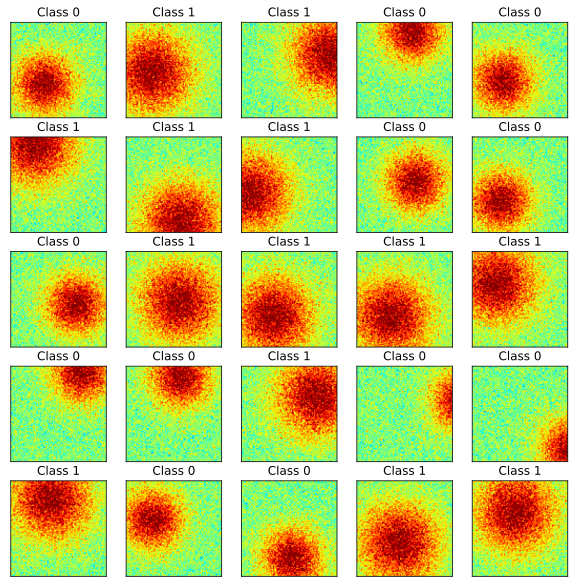

In [3]:
# visualize some images
fig,axs=plt.subplots(5,5,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(2*nPerClass)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap="jet")
    ax.set_title('Class %s'%int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [4]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,labels,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [6]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

In [7]:
# Create the DL model
convOutChannels=[3,6]
imgSize=(91,91)
kernelSize=(3,2)
strideSize=(2,3)
paddingSize=(1,1)
poolSize=(2,2)
fc1_nodes=50

def createNet(lr=0.001):
    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # conv 1
            self.conv1=nn.Conv2d(1,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])
            print("Conv-Pool 1 sizes")
            print(self.outcp1)
            

            # conv 2
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])
            print("Conv-Pool 2 sizes")
            print(self.outcp2)

            # fc1
            self.fci=fcInput(self.outcp2[2],self.outcp2[0])
            print(f"flattened vector size: {(self.fci,1)}")
            self.fc1=nn.Linear(self.fci,fc1_nodes)

            # fc2
            self.output=nn.Linear(fc1_nodes,1)

        def forward(self,x):
            # first conv-pool set
            conv1act=F.relu(self.conv1(x))  
            x=F.avg_pool2d(conv1act,poolSize)

            # second conv-pool set
            conv2act=F.relu(self.conv2(x))  
            x=F.avg_pool2d(conv2act,poolSize)
            

            # FNN part
            x=x.reshape(x.shape[0],-1)
            x=F.relu(self.fc1(x))
            x=self.output(x)
        
            return x,conv1act,conv2act

    # create the model instance
    net=GaussNet()

    # loss function
    lossfun=nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer

In [8]:
# test the model with one batch
net,lossfun,optimizer=createNet()

X,y = next(iter(train_loader))
yHat,featmap1,featmap2=net(X)

# check size of output
print('\nPredicted Category')
print(yHat.shape)
print('\nFeature maps after conv1')
print(featmap1.shape)
print('\nFeature maps after conv2')
print(featmap2.shape)


# now let's compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss: ')
print(loss)

Conv-Pool 1 sizes
(3, (46, 31), (23, 15))
Conv-Pool 2 sizes
(6, (12, 6), (6, 3))
flattened vector size: (108, 1)

Predicted Category
torch.Size([32, 1])

Feature maps after conv1
torch.Size([32, 3, 46, 31])

Feature maps after conv2
torch.Size([32, 6, 12, 6])
 
Loss: 
tensor(0.6916, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [9]:
# count the total number of parameters in the model
summary(net,(1,imgSize[0],imgSize[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 46, 31]              21
            Conv2d-2             [-1, 6, 12, 6]             114
            Linear-3                   [-1, 50]           5,450
            Linear-4                    [-1, 1]              51
Total params: 5,636
Trainable params: 5,636
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


In [10]:
# Create a function that trains the model

def trainModel(train_loader,test_loader,n_epochs=10):
    # create a new model
    net,lossfun,optimizer=createNet()

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)
    trainAcc = tr.zeros(n_epochs)
    testAcc = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]
        batchAcc=[]

        for X,y in train_loader:

            # forward pass and loss
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchAcc.append(tr.mean(((yHat>0.5)==y).float()).item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)
        trainAcc[epochi]=100*np.mean(batchAcc)

        # test accuracy
        X,y=next(iter(test_loader))
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()
        testAcc[epochi]=100*tr.mean(((yHat>0)==y).float()).item() # doubt here

    # end of epochs

    # function output
    return trainLoss,testLoss,trainAcc,testAcc,net

In [11]:
# Run the model and show the results
trainLoss,testLoss,trainAcc,testAcc,net=trainModel(train_loader,test_loader)

Conv-Pool 1 sizes
(3, (46, 31), (23, 15))
Conv-Pool 2 sizes
(6, (12, 6), (6, 3))
flattened vector size: (108, 1)


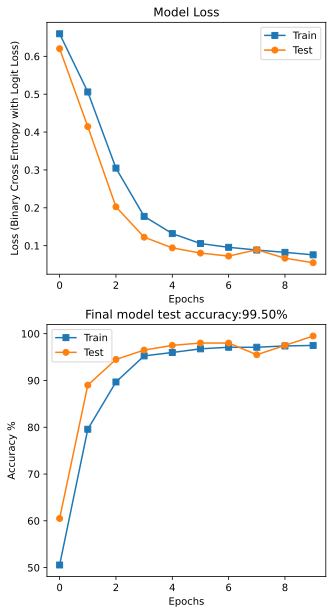

In [12]:
fig,ax=plt.subplots(2,1,figsize=(5,10))

ax[0].plot(trainLoss,'s-',label="Train")
ax[0].plot(testLoss,'o-',label="Test")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (Binary Cross Entropy with Logit Loss)')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label="Train")
ax[1].plot(testAcc,'o-',label="Test")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')
ax[1].set_title(f'Final model test accuracy:{testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

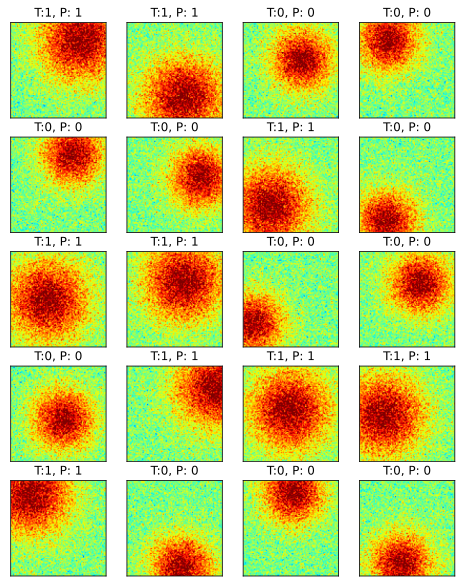

In [13]:
# visualize the output
X,y=next(iter(test_loader)) # extract X,y from the test loader
yHat,featmap1,featmap2=net(X)

fig,axs=plt.subplots(5,4,figsize=(8,10))

for i,ax in enumerate(axs.flatten()):
    G=tr.squeeze(X[i,0,:,:]).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    t=(int(y[i].item())),int(yHat[i].item()>0.5)
    ax.set_title(f'T:{t[0]}, P: {t[1]}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [14]:
net.outcp2[0]

6

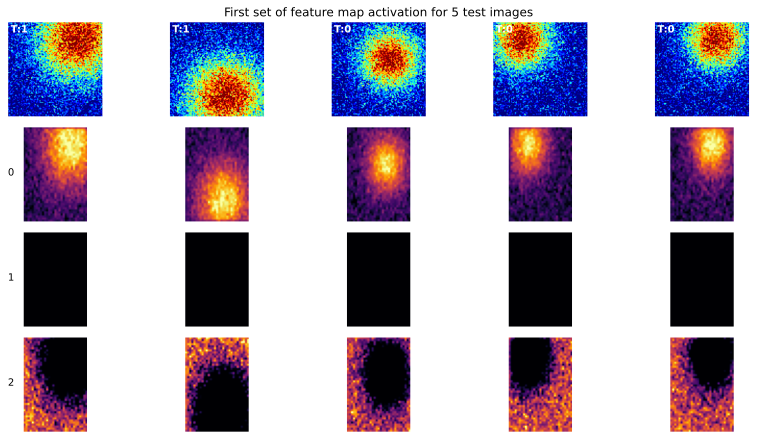

In [16]:
# Draw the feature Maps for first convolutional layer
num_images=5
# output channels + 1 , no of images to be considered
fig,axs=plt.subplots(net.outcp1[0]+1,num_images,figsize=(12,6))

for pici in range(num_images):
    # show the original picture
    img=X[pici,0,:,:].detach()
    axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
    axs[0,pici].axis('off')
    axs[0,pici].text(2,2,f'T:{int(y[pici].item())}',ha='left',va='top',color='w',fontweight='bold')

    for feati in range(net.outcp1[0]):
        # extract the feature map from this image
        img=featmap1[pici,feati,:,:].detach()
        axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=tr.max(img)*0.9)
        axs[feati+1,pici].axis('off')
        axs[feati+1,pici].text(-5,featmap1.shape[2]/2,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activation for 5 test images',x=.5,y=1.01)
plt.show()

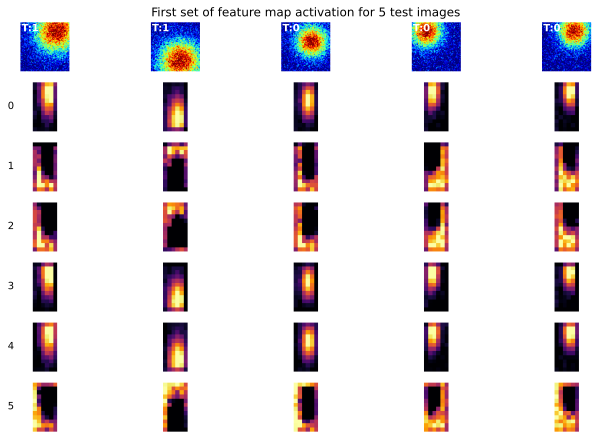

In [15]:
# Draw the feature Maps for second convolutional layer
num_images=5
# output channels + 1 , no of images to be considered
fig,axs=plt.subplots(net.outcp2[0]+1,num_images,figsize=(10,6))

for pici in range(num_images):
    # show the original picture
    img=X[pici,0,:,:].detach()
    axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
    axs[0,pici].axis('off')
    axs[0,pici].text(2,2,f'T:{int(y[pici].item())}',ha='left',va='top',color='w',fontweight='bold')

    for feati in range(net.outcp2[0]):
        # extract the feature map from this image
        img=featmap2[pici,feati,:,:].detach()
        axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=tr.max(img)*0.9)
        axs[feati+1,pici].axis('off')
        axs[feati+1,pici].text(-5,featmap2.shape[2]/2,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle(f'First set of feature map activation for {num_images} test images',x=.5,y=1.01)
plt.show()

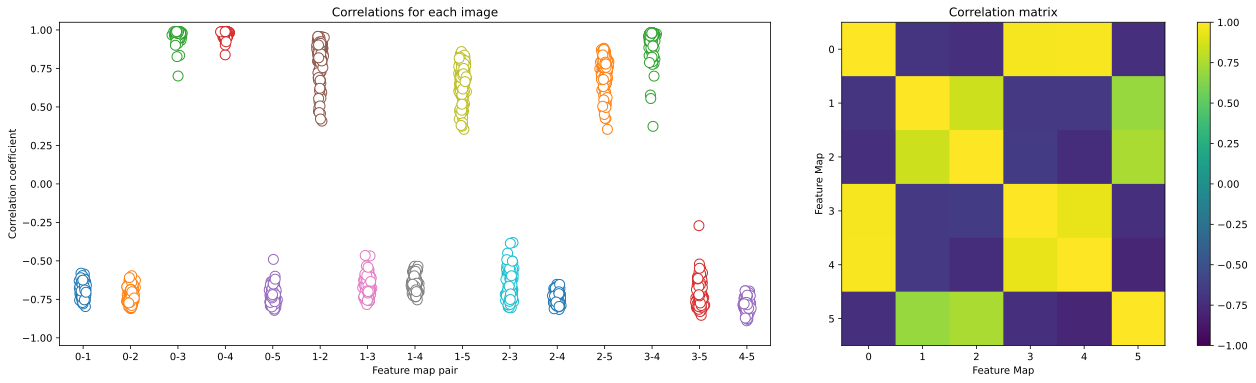

In [17]:
# spatial correlations across the feature maps (second layer)

# convinient variables

nStim=featmap2.shape[0]
nMaps=featmap2.shape[1]
nCors=(nMaps*(nMaps-1))//2

# initialize the matrix of all correlation values
allrs=np.zeros((nStim,nCors))
Call=np.zeros((nMaps,nMaps))

# loop for each stimuli
for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps=featmap2[i,:,:,:].view(nMaps,-1).detach()

    # compute the correlation matrix
    C=np.corrcoef(featmaps)
    Call+=C

    # extract the unique correlations from the matrix
    idx=np.nonzero(np.triu(C,1))
    allrs[i,:]=C[idx]

    # define the x-axis labels
    xlab=[]*nCors
    for i in range(nCors):
        xlab.append(f'{idx[0][i]}-{idx[1][i]}')

# visualizing the correlations
fig=plt.figure(figsize=(18,5))
ax0=fig.add_axes([0.1,0.1,0.55,0.9]) # [left, bottom, width, height]
ax1=fig.add_axes([0.68,0.1,0.3,0.9])
cax=fig.add_axes([0.98,0.1,0.01,0.9])

for i in range(nCors):
    ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-0.5,nCors-0.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')

# now show the average correlation matrix
h=ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature Map')
ax1.set_ylabel('Feature Map')
# add a colorbar
fig.colorbar(h,cax=cax)
plt.show()

/home/rudraksha14/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rudraksha14/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


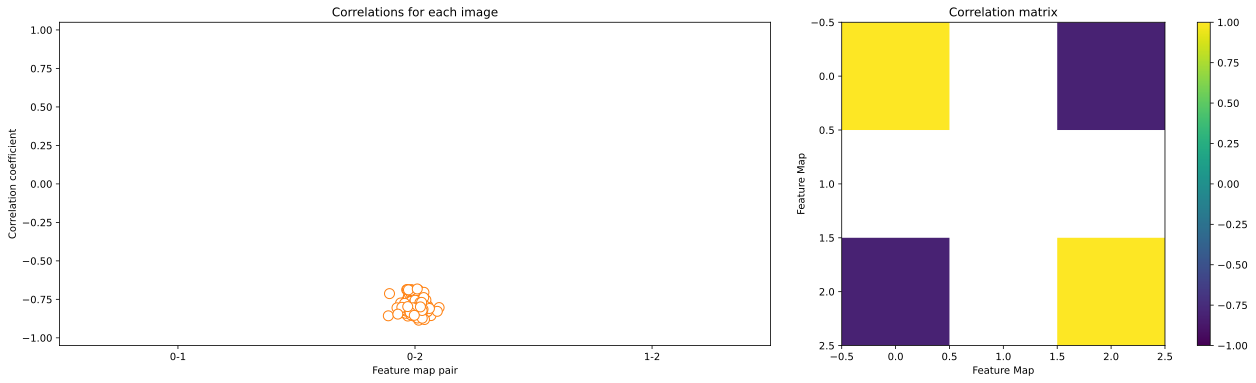

In [18]:
# spatial correlations across the feature maps (second layer)

# convinient variables

nStim=featmap1.shape[0]
nMaps=featmap1.shape[1]
nCors=(nMaps*(nMaps-1))//2

# initialize the matrix of all correlation values
allrs=np.zeros((nStim,nCors))
Call=np.zeros((nMaps,nMaps))

# loop for each stimuli
for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps=featmap1[i,:,:,:].view(nMaps,-1).detach()

    # compute the correlation matrix
    C=np.corrcoef(featmaps)
    Call+=C

    # extract the unique correlations from the matrix
    idx=np.nonzero(np.triu(C,1))
    allrs[i,:]=C[idx]

    # define the x-axis labels
    xlab=[]*nCors
    for i in range(nCors):
        xlab.append(f'{idx[0][i]}-{idx[1][i]}')

# visualizing the correlations
fig=plt.figure(figsize=(18,5))
ax0=fig.add_axes([0.1,0.1,0.55,0.9]) # [left, bottom, width, height]
ax1=fig.add_axes([0.68,0.1,0.3,0.9])
cax=fig.add_axes([0.98,0.1,0.01,0.9])

for i in range(nCors):
    ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-0.5,nCors-0.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')

# now show the average correlation matrix
h=ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature Map')
ax1.set_ylabel('Feature Map')
# add a colorbar
fig.colorbar(h,cax=cax)
plt.show()